In [1]:
from torchvision.transforms.v2.functional import elastic_transform
%load_ext autoreload
%autoreload 2
import math
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils
import torch.utils.data
import torch.nn as nn
import torchsummary
import torch.nn.functional as F
import numpy as np
import cv2
import gc
from scipy import ndimage
from livenet.backend.core import Context
import random
import importlib
import onnx
import livenet
device = "cuda"
#device = "cpu"
torch.set_default_device(device)
from ai_libs.simple_log import LOG



In [2]:
test_x, test_y = livenet.datasets.get_cifar10_test()
train_x, train_y = livenet.datasets.get_cifar10_train()

test_x = test_x.cpu().numpy()
test_y = test_y.cpu().numpy()
train_x = train_x.cpu().numpy()
train_y = train_y.cpu().numpy()


In [9]:
train_x, train_y = livenet.datasets.augment_vertical_flip(train_x, train_y)
train_x_elastic, train_y_elastic = livenet.datasets.get_augmented_eight_elastic_shifts(train_x, train_y, 4)
train_x_rot_shift, train_y_rot_shift = livenet.datasets.get_augmented_ten_rotations_and_shifts(train_x, train_y, 12, 4)
train_x = np.concatenate((train_x, train_x_elastic, train_x_rot_shift), axis=0)
train_y = np.concatenate((train_y, train_y_elastic, train_y_rot_shift), axis=0)
train_x, train_y = livenet.datasets.permutate_sync(train_x, train_y)



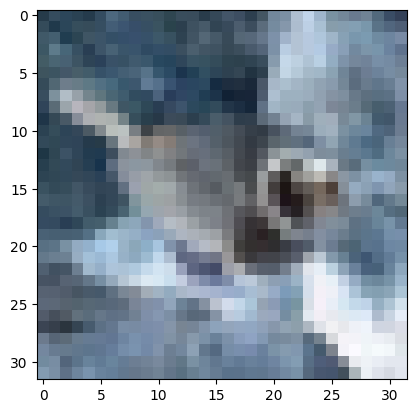

In [93]:
img = train_x[90].numpy()
img = img.transpose(1, 2, 0)
from matplotlib import pyplot as plt
img = elastic_transform(img, (-0, 0))
plt.imshow( 1-((img *0.5)+0.5))

In [32]:

class ResBlock(nn.Module):
    def __init__(self, input_channels: int, internal_channels: int):
        super().__init__()
        self.c1 = nn.Conv2d(input_channels, internal_channels, 1)
        self.c2 = nn.Conv2d(internal_channels, internal_channels, 3, groups=internal_channels, padding="same")
        self.c3 = nn.Conv2d(internal_channels, input_channels, 1)
        self.bn1 = nn.BatchNorm2d(internal_channels)
        self.bn2 = nn.BatchNorm2d(internal_channels)
        self.bn3 = nn.BatchNorm2d(input_channels)

    def forward(self, x):
        y = F.relu(self.bn1(self.c1(x)))
        y = F.relu(self.bn2(self.c2(y)))
        y = F.relu(self.bn3(self.c3(y)))
        return x + y

def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(0)
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self._alpha = 0.01
        self.context = Context(self)
        self.blocks = dict()
        self.max_pool = nn.MaxPool2d(2, 2)
        self.av_pool = nn.AvgPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 16, 3, groups=16)
        self.conv3 = nn.Conv2d(16, 16, 1)
        self.conv4 = nn.Conv2d(16, 32, 1)
        self.r1 = ResBlock(32, 64)
        self.conv5 = nn.Conv2d(32, 64, 1)
        self.conv6 = nn.Conv2d(64, 64, 3, groups=64, stride=2)
        self.conv7 = nn.Conv2d(64, 40, 1)
        self.r2 = ResBlock(40, 128)
        self.conv8 = nn.Conv2d(40, 128, 1)
        self.conv9 = nn.Conv2d(128, 128, 3, groups=128, stride=2)
        self.conv10 = nn.Conv2d(128, 64, 1)

        self.conv11 = nn.Conv2d(64, 128, 1)
        self.conv12 = nn.Conv2d(128, 128, 3, groups=128, stride=2)

        self.dr7 = nn.Dropout(p=0.2)
        self.dr8 = nn.Dropout(p=0.2)
        self.dr10 = nn.Dropout(p=0.2)
        self.dr11 = nn.Dropout(p=0.2)

        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc1b = nn.Linear(64, 10)

        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(16)
        self.bn4 = nn.BatchNorm2d(32)

        self.bn5 = nn.BatchNorm2d(64)
        self.bn6 = nn.BatchNorm2d(64)
        self.bn7 = nn.BatchNorm2d(40)

        self.bn8 = nn.BatchNorm2d(128)
        self.bn9 = nn.BatchNorm2d(128)
        self.bn10 = nn.BatchNorm2d(64)

        self.bn11 = nn.BatchNorm2d(128)
        self.bn12 = nn.BatchNorm2d(128)

        self.fc = nn.Linear(128, 10)
        self.drfc = nn.Dropout(p=0.5)


    def forward(self, x):
        x = F.relu6(self.bn1(self.conv1(x)))
        x = F.relu6(self.bn2(self.conv2(x)))
        x = F.relu6(self.bn3(self.conv3(x)))
        x = F.relu6(self.bn4(self.conv4(x)))
        x = self.r1(x)
        x = F.relu6(self.bn5(self.conv5(x)))
        x = F.relu6(self.bn6(self.conv6(x)))
        x = F.relu6(self.bn7(self.conv7(x)))
        # x = self.dr7(x)
        x = self.r2(x)
        x = F.relu6(self.bn8(self.conv8(x)))
        # x = self.dr8(x)
        x = F.relu6(self.bn9(self.conv9(x)))
        x = F.relu6(self.bn10(self.conv10(x)))
        # x = self.dr10(x)

        x = F.relu6(self.bn11(self.conv11(x)))
        # x = self.dr11(x)
        x = F.relu6(self.bn12(self.conv12(x)))

        x = self.av_pool(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #x = self.drfc(x)

        x=self.fc(x)
        return x

    def internal_loss(self):
        loss = torch.tensor(0.)
        for param in self.parameters():
            if len(param.data.shape) > 1:
                # loss += self._alpha * torch.sum(torch.abs(param)) / param.data.numel()
                loss += self._alpha * torch.sum(torch.square(param)) / param.data.numel()
        return loss


network = Net()
torchsummary.summary(network, (3, 32, 32), device=device)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             448
       BatchNorm2d-2           [-1, 16, 30, 30]              32
            Conv2d-3           [-1, 16, 28, 28]             160
       BatchNorm2d-4           [-1, 16, 28, 28]              32
            Conv2d-5           [-1, 16, 28, 28]             272
       BatchNorm2d-6           [-1, 16, 28, 28]              32
            Conv2d-7           [-1, 32, 28, 28]             544
       BatchNorm2d-8           [-1, 32, 28, 28]              64
            Conv2d-9           [-1, 64, 28, 28]           2,112
      BatchNorm2d-10           [-1, 64, 28, 28]             128
           Conv2d-11           [-1, 64, 28, 28]             640
      BatchNorm2d-12           [-1, 64, 28, 28]             128
           Conv2d-13           [-1, 32, 28, 28]           2,080
      BatchNorm2d-14           [-1, 32,

In [33]:
batch_size = 256
batch_iterator = livenet.gen_utils.batch_iterator(train_x, train_y, batch_size)
criterion = livenet.nets.criterion_classification_n
optimizer = livenet.nets.create_optimizer(network)
epoch_size = len(train_x) // batch_size // 10
trainer = livenet.net_trainer.NetTrainer(network, batch_iterator, criterion, optimizer, epoch_size)
trainer.adaptive_lr = True
optimizer.learning_rate = 0.01



Torch


In [34]:
#network.learning_rate = 0.0005
# optimizer.learning_rate /= 2
network.train()
trainer.step(300000)


Iˈ0.000 741 1.861+0.009reg params=78 lr=0.01000 <string>:34
Iˈ25.573 1483 1.269+0.021reg params=78 lr=0.01000 <string>:34
Iˈ51.617 2225 1.083+0.031reg params=78 lr=0.01000 <string>:34
Iˈ77.495 2967 0.986+0.041reg params=78 lr=0.01000 <string>:34
Iˈ104.005 3709 0.920+0.049reg params=78 lr=0.01000 <string>:34
Iˈ130.954 4451 0.876+0.056reg params=78 lr=0.01000 <string>:34
Iˈ157.698 5193 0.837+0.063reg params=78 lr=0.01000 <string>:34
Iˈ185.380 5935 0.825+0.069reg params=78 lr=0.01000 <string>:34
Iˈ213.400 6677 0.791+0.074reg params=78 lr=0.01000 <string>:34
Iˈ241.517 7419 0.761+0.078reg params=78 lr=0.01000 <string>:34
Iˈ293.398 8161 0.735+0.083reg params=78 lr=0.01000 <string>:34
Iˈ327.416 8903 0.720+0.087reg params=78 lr=0.01000 <string>:34
Iˈ359.720 9645 0.703+0.090reg params=78 lr=0.01000 <string>:34
Iˈ389.982 10387 0.697+0.094reg params=78 lr=0.01000 <string>:34
Iˈ417.939 11129 0.681+0.097reg params=78 lr=0.01000 <string>:34
Iˈ446.171 11871 0.671+0.100reg params=78 lr=0.01000 <string

In [36]:
gc.collect()
torch.cuda.empty_cache()

def _infer_in_chunks(network, data):
    chunk_size = 256
    n = len(data)
    preds = []
    for i in range( (n + chunk_size - 1) // chunk_size):
        start = i * chunk_size
        end = min((i + 1) * chunk_size, n)
        chunk = data[start:end]
        chunk = torch.tensor(chunk).to(device)
        with torch.no_grad():
            pred = network(chunk)
            pred = pred.cpu()
            preds.append(pred)
    result = torch.concatenate(preds, dim=0)
    return result


network.train()
with torch.no_grad():
    #train_pred = _infer_in_chunks(network, train_x)
    test_pred = _infer_in_chunks(network, test_x)
    pass

network.eval()
with torch.no_grad():
    train_pred = _infer_in_chunks(network, train_x)
    test_pred = _infer_in_chunks(network, test_x)

def calc_accuracy(predictions, labels):
    _, predicted = torch.max(predictions.data, 1)
    labels = labels.cpu().numpy()
    labels = np.squeeze(labels, 1)
    predicted = predicted.cpu().numpy()
    correct = np.sum(predicted == labels)
    total = len(labels)
    accuracy = correct / total
    return accuracy


test_y_tensor = torch.tensor(test_y, device="cpu")
train_y_tensor = torch.tensor(train_y, device="cpu")
test_loss = trainer.criterion(test_pred, test_y_tensor).cpu().item()
train_loss = trainer.criterion(train_pred, train_y_tensor).cpu().item()
LOG(f"loss: train: {train_loss:.3f} test: {test_loss:.3f}")

test_accuracy = calc_accuracy(test_pred, test_y_tensor)
train_accuracy = calc_accuracy(train_pred, train_y_tensor)
LOG(f"accuracy, train: {100 * train_accuracy:.1f}% test: {100 * test_accuracy:.1f}%")

Iˈ0.000 loss: train: 0.205 test: 0.664 
Iˈ0.009 accuracy, train: 94.9% test: 88.2% 
